# Задание

*
    1. Из небольшого объема исходных изображений (картинок) с использованием алгоритмов кластеризации найти похожие. 
    2. В выводах обосновать какие метрики и алгоритмы лучше использовать для решения вышеизложенных задач.
* 
    1. Из текстуальных данных с использованием алгоритмов кластеризации найти похожие. 
    2. В выводах обосновать какие метрики и алгоритмы лучше использовать для решения вышеизложенных задач.


In [355]:
from sklearn.cluster import KMeans
from sklearn.metrics import homogeneity_completeness_v_measure
from sklearn.decomposition import TruncatedSVD

import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Кластеризация изображений

## Подготовка данных

In [356]:
def load_data(path):
    X = []
    y = []

    category = 0
    for _, dirs, __ in os.walk(path):
        for dir in dirs:
            subpath = os.path.join(path, dir)

            paths = [os.path.join(subpath, entry) for entry in os.listdir(subpath) if os.path.isfile(os.path.join(subpath, entry))]
            paths = paths[::70]
            new_objects = [cv2.imread(entry_path) for entry_path in paths]
            
            X += new_objects
            y += [category] * len(new_objects)

            category += 1
    
    return np.array([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in X]), np.array(y)

In [357]:
X, y = load_data('./shapes')
count, rows, cols = X.shape

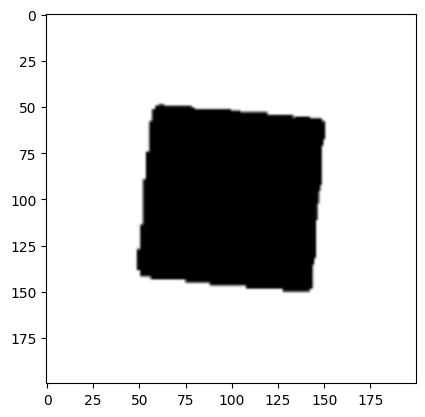

In [358]:
X = np.array([img.reshape(rows * cols) for img in X])
plt.imshow(X[0].reshape(rows, cols), interpolation='bicubic')

In [359]:
def plot_mean(model):
    plt.gray()
    for center in model.cluster_centers_:
        plt.imshow(center.reshape(rows, cols), interpolation='bicubic')
        plt.show()

In [360]:
def compute_metrics(clusters):
    h, c, v = homogeneity_completeness_v_measure(y, clusters)
    print(f"Metrics:\n\tHomogeneity: {h}\n\tCompleteness: {c}\n\tV-score: {v}")
    return np.array([h, c, v])

## KMeans

### Raw data

In [361]:
km = KMeans(n_clusters=4, n_init=100, random_state=123)
km_clusters = km.fit_predict(X)

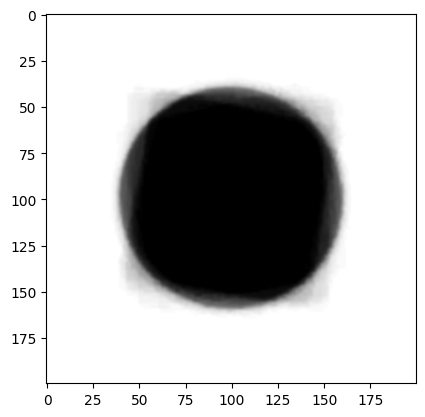

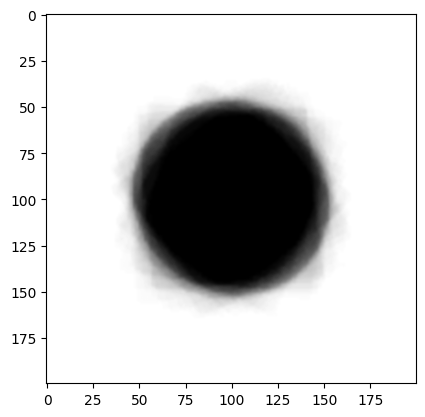

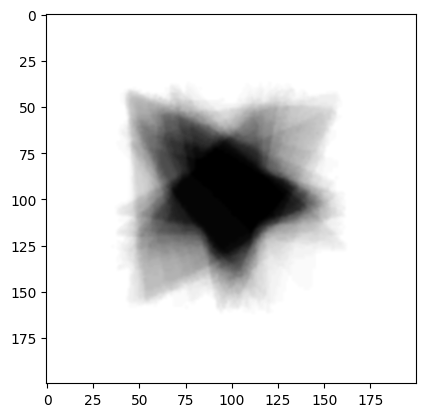

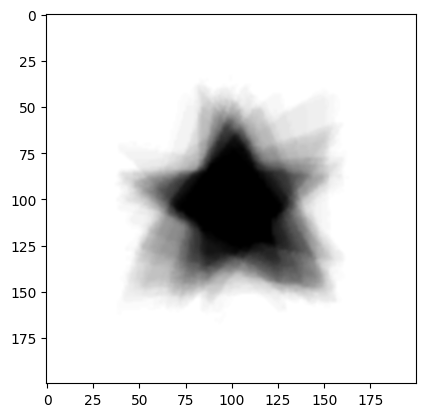

In [362]:
plot_mean(km)

In [363]:
compute_metrics(km_clusters);

Metrics:
	Homogeneity: 0.5169449343583291
	Completeness: 0.5222683381259479
	V-score: 0.5195930015877208


Как видно по картинкам, результаты не очень. Пробуем улучшить метрики.

### Понижение размерности

In [364]:
from sklearn.manifold import TSNE

In [365]:
tsne = TSNE(n_components=2, init='random', learning_rate='auto', random_state=123)
X_tsne = tsne.fit_transform(X)

In [366]:
km = KMeans(n_clusters=4, n_init=100, random_state=123)
km_clusters = km.fit_predict(X_tsne)

In [367]:
compute_metrics(km_clusters);

Metrics:
	Homogeneity: 0.5226124683905892
	Completeness: 0.5285380639300815
	V-score: 0.5255585641364967


Стало самую малость лучше

### Полярно-логарифмическая система координат

Пробуем перевести данные в систему координат, которая инвариантна к поворотам.

In [368]:
def to_polar_log(img):
    return cv2.warpPolar(img, dsize=(rows, cols), center=(rows/2, cols/2), maxRadius=rows/2, flags=cv2.WARP_POLAR_LOG).reshape(rows * cols)

In [369]:
polar_X = np.array([to_polar_log(img.reshape(rows, cols)) for img in X])

In [370]:
km = KMeans(n_clusters=4, n_init=100, random_state=123)
km_clusters = km.fit_predict(polar_X)

In [371]:
compute_metrics(km_clusters);

Metrics:
	Homogeneity: 0.5003019796235841
	Completeness: 0.5634549415963828
	V-score: 0.530003832804336


Есть продвижение по *полноте* и *v-score*.

### Понижение размерности и полярно-логарифмическая система координат

In [372]:
tsne = TSNE(n_components=2, init='random', learning_rate='auto', random_state=123)
polar_X_tsne = tsne.fit_transform(polar_X)

In [373]:
km = KMeans(n_clusters=4, n_init=100, random_state=123)
km_clusters = km.fit_predict(polar_X_tsne)
compute_metrics(km_clusters);

Metrics:
	Homogeneity: 0.5526368732616465
	Completeness: 0.5619821412550334
	V-score: 0.5572703306281502


Получилось добиться максимальных метрик по всем, кроме *полноты*, но отставание по ней незначительное.

## AgglomerativeClustering

In [374]:
from sklearn.cluster import AgglomerativeClustering

### Raw data

In [375]:
ac = AgglomerativeClustering(n_clusters=4)
ac_clusters = ac.fit_predict(X)
compute_metrics(ac_clusters);

Metrics:
	Homogeneity: 0.5825924974187379
	Completeness: 0.6170578674329222
	V-score: 0.599330095788499


С ходу максимальный результат...

### Понижение размерности

In [376]:
ac = AgglomerativeClustering(n_clusters=4)
ac_clusters = ac.fit_predict(X_tsne)
compute_metrics(ac_clusters);

Metrics:
	Homogeneity: 0.5176492255838665
	Completeness: 0.5180659133842662
	V-score: 0.5178574856633725


Не то.

### Полярно-логарифмическая система координат

In [377]:
ac = AgglomerativeClustering(n_clusters=4)
ac_clusters = ac.fit_predict(polar_X)
compute_metrics(ac_clusters);

Metrics:
	Homogeneity: 0.5065997431055076
	Completeness: 0.5773431420632749
	V-score: 0.5396629129724649


### Понижение размерности и полярно-логарифмическая система координат

In [378]:
ac = AgglomerativeClustering(n_clusters=4)
ac_clusters = ac.fit_predict(polar_X_tsne)
compute_metrics(ac_clusters);

Metrics:
	Homogeneity: 0.5937913355656708
	Completeness: 0.620856564545018
	V-score: 0.6070224113873741


Лучший результат!

# Вывод.
В целом метрики получились низкие. `AgglomerativeClustering` сходу дал на "сырых" данных лучший результат, чем `KMeans` со всеми модификациями. Удалось добиться небольшого прироста за счет понижения размерности и смены системы координат изображения в инвариантную к ориентации.